## Qiskit Metal and Ansys implemetation
The main idea of this project is to take all the information about the lattice from the code before and put it all together to implement the quantum chip.  
For more information about how to use Qiskit Metal you use the following guide (made by me) or the original literature LINK.  
In this code all the implementations was designed using the transmon like qubit with four ports.

In [1]:
import numpy as np
from IPython.display import Image
from qiskit_metal import designs, draw, MetalGUI, Dict, open_docs
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
%metal_heading Towards an Useful Quantum Chip

This two functions generalize the connections from "Qubit to Qubit" for connect two different qubits via CPW (Co-planar Wave) Resonator and "Qubit to Path".

In [2]:
# Build Functions:
def cpw_connect_qxq(design, Q1, Q2, PIN_1, PIN_2, COM_Q1, COM_Q2):

    cpw_options = Dict(
        fillet='90um',
        hfss_wire_bonds = True,
        pin_inputs=Dict(
                start_pin=Dict(
                    component=COM_Q1+str(Q1),
                    pin=PIN_1),
                end_pin=Dict(
                    component=COM_Q2+str(Q2),
                    pin=PIN_2)),
        total_length='25mm', #5
        lead=Dict(
                start_straight='0.8mm',
                end_straight='0.8mm'),
            trace_gap='7um',
            trace_width='10um')

    cpw1 = RouteMeander(design, 'cpw_'+str(Q1)+'_'+str(2)+'_'+str(Q2), cpw_options)

    return 'cpw_'+str(Q1)+'_'+str(2)+'_'+str(Q2)

In [3]:
# Build Functions:

def cpw_connect_qxp(design, Q1, Q2, PIN_1, PIN_2, COM_Q1, COM_Q2):

    cpw_options = Dict(
        fillet='90um',
        hfss_wire_bonds = True,
        pin_inputs=Dict(
                start_pin=Dict(
                    component=COM_Q1+str(Q1),
                    pin=PIN_1),
                end_pin=Dict(
                    component=COM_Q2+str(Q2),
                    pin=PIN_2)),
        total_length='25mm', #5
        lead=Dict(
                start_straight='0.2mm',
                end_straight='0.2mm'),
            trace_gap='5um',
            trace_width='8um')

    cpw1 = RouteMeander(design, 'cpw_'+str(Q1)+'_'+str(2)+'_'+str(Q2), cpw_options)

    return 'cpw_'+str(Q1)+'_'+str(2)+'_'+str(Q2)

## Create the chip, load information and put it all together.

In [4]:
# Create the chip.
design = designs.DesignPlanar()
design.overwrite_enabled = True
design.chips.main
design.chips.main.size.size_x = '80mm'#11mm
design.chips.main.size.size_y = '78mm'#9mm
gui = MetalGUI(design)

## Load all the information:

In [5]:
# Load the coordinates from the previous codes.
total_array = np.load("coords.npy")
connectivity = np.load("connectivity.npy")
pins = np.load("pins.npy")
launch_path_left = np.load("left_path.npy")
launch_path_right = np.load("right_path.npy")
launch = np.load("paths.npy")
general_path = np.load("general_paths.npy")
ground = np.load("ground.npy")

## Create all the qubits:

In [6]:
# Put all the qubits in the architectures from the total_array data.
qubits_name = []

for i in range(len(total_array)):
    options = dict(pos_x= str(total_array[i][0]*1000)+'um', pos_y = str(total_array[i][1]*1000)+'um', orientation = "360",
                    connection_pads = dict(
                        A = dict(loc_W=-1, loc_H=+1, pad_width='75um'),
                        B  = dict(loc_W=-1, loc_H=-1, pad_width='120um'),
                        C  = dict(loc_W=+1, loc_H=+1, pad_width='120um'),
                        D = dict(loc_w = +1, loc_H = -1, pad_width='90um')))

    obj=TransmonPocket(design,'Q_'+str(i),options)
    print("Creating Qubit --→ Q_"+str(i))
    qubits_name.append('Q_'+str(i))

gui.rebuild()
gui.autoscale()

print(qubits_name)

Creating Qubit --→ Q_0
Creating Qubit --→ Q_1
Creating Qubit --→ Q_2
Creating Qubit --→ Q_3
Creating Qubit --→ Q_4
Creating Qubit --→ Q_5
['Q_0', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5']


## Create the connection from qubit to qubit:

In [7]:
# Connect all the qubits using the connectivity and pins data.
cpw_names = []

for i in range(len(connectivity)):
    cpw_names.append(cpw_connect_qxq(design, connectivity[i][0], connectivity[i][1], pins[i][0], pins[i][1], 'Q_', 'Q_'))
    print("Creating CPW from Q_{} to Q_{} :".format(connectivity[i][0], connectivity[i][1]))

print(cpw_names)

gui.rebuild()
gui.autoscale()

Creating CPW from Q_0 to Q_1 :
Creating CPW from Q_1 to Q_4 :
Creating CPW from Q_2 to Q_3 :
Creating CPW from Q_3 to Q_4 :
Creating CPW from Q_4 to Q_5 :
['cpw_0_2_1', 'cpw_1_2_4', 'cpw_2_2_3', 'cpw_3_2_4', 'cpw_4_2_5']


## Create the launch paths for sending control signals:

In [8]:
# Create the launch paths from the launch data
lp_names = []

for i in range(len(launch)):
    if i%2 ==0:
        launch_options = dict(pos_x= str(launch[i][0]*1000)+'um', pos_y=str(launch[i][1]*1000)+'um', orientation='180', lead_length='10um')
        lp = LaunchpadWirebondCoupled(design, 'PQ_'+str(i), options = launch_options)
    else:
        launch_options = dict(pos_x= str(launch[i][0]*1000)+'um', pos_y=str(launch[i][1]*1000)+'um', orientation='0', lead_length='10um')
    lp = LaunchpadWirebondCoupled(design, 'PQ_'+str(i), options = launch_options)
    print("Creating Path PQ_{}:".format('PQ_'+str(i)))

gui.rebuild()
gui.autoscale()

Creating Path PQ_PQ_0:
Creating Path PQ_PQ_1:
Creating Path PQ_PQ_2:
Creating Path PQ_PQ_3:
Creating Path PQ_PQ_4:
Creating Path PQ_PQ_5:


## Create the connections to control paths to qubits.

In [9]:
for i in range(len(launch)):
    if i%2==0:
        cpw_connect_qxp(design, i, i, 'D', 'tie', 'Q_', 'PQ_')
    else:
        cpw_connect_qxp(design, i, i, 'B', 'tie', 'Q_', 'PQ_')
    print("Creating CPW from Q_{} to PQ_{} :".format(i, i))

gui.rebuild()
gui.autoscale()

Creating CPW from Q_0 to PQ_0 :
Creating CPW from Q_1 to PQ_1 :
Creating CPW from Q_2 to PQ_2 :
Creating CPW from Q_3 to PQ_3 :
Creating CPW from Q_4 to PQ_4 :
Creating CPW from Q_5 to PQ_5 :


## Close the circuit for measurement

In [10]:

launch_options = dict(pos_x= str(general_path[0][0]*1000)+'um', pos_y=str(general_path[0][1]*1000)+'um', orientation='0', lead_length='10um')
lp = LaunchpadWirebondCoupled(design, 'GPQ_'+str(0), options = launch_options)

launch_options = dict(pos_x= str(general_path[1][0]*1000)+'um', pos_y=str(general_path[1][1]*1000)+'um', orientation='0', lead_length='10um')
lp = LaunchpadWirebondCoupled(design, 'GPQ_'+str(1), options = launch_options)

ground_path = OpenToGround(design,'G_'+str(0), options= Dict(pos_x=str(ground[1][0]*1001)+'um' ,pos_y=str(ground[1][1]*1001)+'um' , orientation = '0'))
ground_path = OpenToGround(design,'G_'+str(1), options= Dict(pos_x=str(ground[1][0]*999)+'um' ,pos_y=str(ground[1][1]*999)+'um' , orientation = '0'))

ground_path = OpenToGround(design,'G_'+str(2), options= Dict(pos_x=str(ground[0][0]*1001)+'um' ,pos_y=str(ground[0][1]*1001)+'um' , orientation = '0'))
ground_path = OpenToGround(design,'G_'+str(3), options= Dict(pos_x=str(ground[0][0]*999)+'um' ,pos_y=str(ground[0][1]*999)+'um' , orientation = '0'))

ground_path = OpenToGround(design,'G_'+str(4), options= Dict(pos_x=str(general_path[0][0]*800)+'um' ,pos_y=str(general_path[0][1]*1000)+'um' , orientation = '0'))
ground_path = OpenToGround(design,'G_'+str(5), options= Dict(pos_x=str(general_path[1][0]*800)+'um' ,pos_y=str(general_path[1][1]*1000)+'um' , orientation = '0'))

testStraight = RouteStraight(design,'S_'+str(0), options=Dict(pin_inputs=Dict(
                                                                    start_pin=Dict(
                                                                        component = 'GPQ_0',
                                                                        pin = 'tie'),
                                                                    end_pin=Dict(
                                                                        component = 'G_0',
                                                                        pin = 'open')
                                                                    )))

testStraight = RouteStraight(design,'S_'+str(1), options=Dict(pin_inputs=Dict(
                                                                    start_pin=Dict(
                                                                        component = 'G_1',
                                                                        pin = 'open'),
                                                                    end_pin=Dict(
                                                                        component = 'G_2',
                                                                        pin = 'open')
                                                                    )))

testStraight = RouteStraight(design,'S_'+str(2),options=Dict(pin_inputs=Dict(
                                                                    start_pin=Dict(
                                                                        component = 'G_3',
                                                                        pin = 'open'),
                                                                    end_pin=Dict(
                                                                        component = 'GPQ_1',
                                                                        pin = 'tie')
                                                                    )))

testStraight = RouteStraight(design,'S_'+str(3),options=Dict(pin_inputs=Dict(
                                                                    start_pin=Dict(
                                                                        component = 'G_4',
                                                                        pin = 'open'),
                                                                    end_pin=Dict(
                                                                        component = 'G_5',
                                                                        pin = 'open')
                                                                    )))

gui.rebuild()
gui.autoscale()

Results?

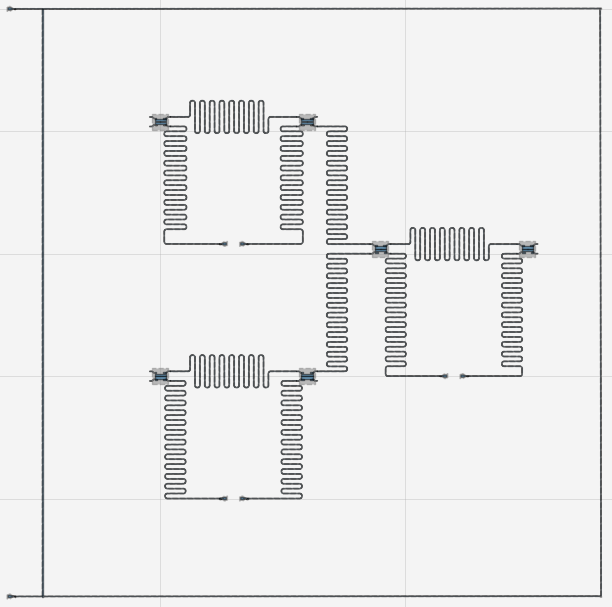

In [11]:
Image(filename="Images/Chip_Metal_6.png")

# The following is a image from a architecture of 24 qubits. 

You can create this same architecture with this code!

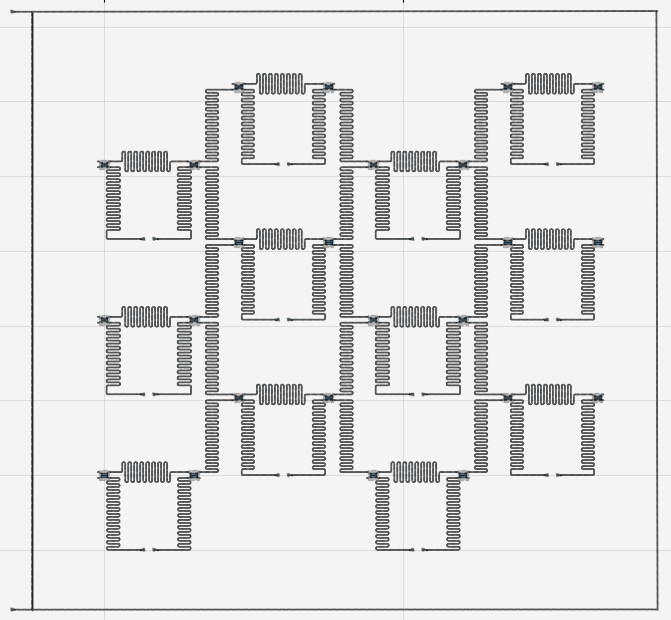

In [12]:
Image(filename="Images/Chip_Metal_24.png")

# Qiskit Metal to Ansys Analysis

## Ansys Initialization

In [ ]:
# Take ~1:20 min to initialization
ansys = design.renderers.hfss
ansys.start()

In [14]:
ansys_design = ansys.new_ansys_design("Name_Project", 'eigenmode')
# What are the difference for eigenmode & drivenmodal

INFO 05:52PM [connect_design]: 	Opened active design
	Design:    Name_Project [Solution type: Eigenmode]
WARNING 05:52PM [connect_setup]: 	No design setup detected.
WARNING 05:52PM [connect_setup]: 	Creating eigenmode default setup.
INFO 05:52PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [ ]:
# Depending of your design, this could take 2.5 min per qubit + resonator.
ansys.render_design()

In [ ]:
ansys.stop()

Results?

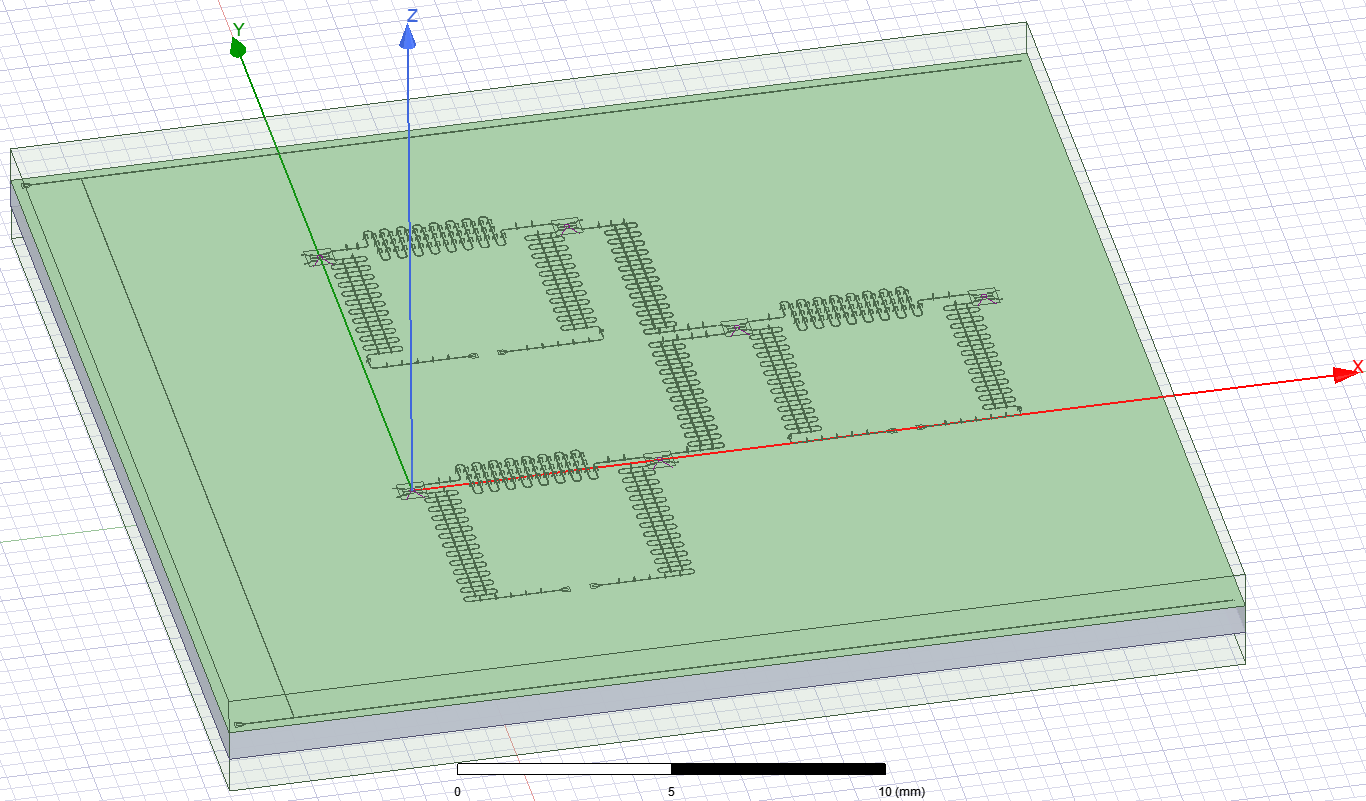

In [16]:
Image(filename="Images/Ansys.png")

I am pretty sure that you can improve this even more, then go ahead!